In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
# se utiliza para el manejo de rutas y directorios.
import os

# Calculo cientifico y vectorial para python
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Librerias para graficar
from matplotlib import pyplot

# Modulo de optimización de scipy
from scipy import optimize

from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D  # Necesario para graficar superficies 3D

from sklearn.model_selection import train_test_split
import tabulate



# llama a matplotlib a embeber graficas dentro de los cuadernillos
%matplotlib inline

# le dice a matplotlib que incruste gráficos en el cuaderno
%matplotlib inline

## 1 Regresion Logistica

En esta parte del ejercicio, creará un modelo de regresión logística para predecir si un estudiante será admitido en una universidad. Suponga que es el administrador de un departamento universitario y desea determinar las posibilidades de admisión de cada solicitante en función de sus resultados en dos exámenes. Tiene datos históricos de solicitantes anteriores que puede usar como un conjunto de capacitación para la regresión logística. Para cada ejemplo de capacitación, se tiene las calificaciones del solicitante en dos exámenes y la decisión de admisión. Su tarea es crear un modelo de clasificación que calcule la probabilidad de admisión de un solicitante en función de los puntajes de esos dos exámenes.

La siguiente celda cargará los datos y las etiquetas correspondientes:

In [8]:
# Cargar datos
data = pd.read_csv("Covid Data.csv")
data



data = data.drop(['DATE_DIED'], axis=1).astype(float)


train_dataset, test_dataset = train_test_split(data, test_size=0.2, random_state=42)

X_test = test_dataset.drop(['OBESITY'], axis=1).values
y_test = test_dataset['OBESITY'].values


X_train = train_dataset.drop(['OBESITY'], axis=1).values
y_train = train_dataset['OBESITY'].values

### 1.1 Visualizar los datos

Antes de comenzar a implementar cualquier algoritmo de aprendizaje, siempre es bueno visualizar los datos si es posible. Mostramos los datos en una gráfica bidimensional llamando a la función `plotData`. Se completará el código en `plotData` para que muestre una figura donde los ejes son los dos puntajes de los dos examenes, los ejemplos positivos y negativos se muestran con diferentes marcadores.

In [15]:
def plotData(X, y):
    # Gragica los puntos de datos X y y en una nueva figura. Grafica los puntos de datos con * para los positivos y
    # o para los negativos.

    # Crea una nueva figura
    fig = pyplot.figure()

    # Find Indices of Positive and Negative Examples
    pos = y == 1
    neg = y == 0

    # Plot Examples
    pyplot.plot(X[pos, 0], X[pos, 1], 'k*', lw=2, ms=10)
    pyplot.plot(X[neg, 0], X[neg, 1], 'ko', mfc='y', ms=8, mec='k', mew=1)


Se llama a la función implementada para mostrar los datos cargados:

In [14]:
# plotData(X, y)
# # adiciona etiquetas para los ejes
# pyplot.xlabel('Calificación Examen 1')
# pyplot.ylabel('Calificación Examen 2')
# pyplot.legend(['Admitido', 'No admitido'])
# pass

<a id="section1"></a>
### 1.2 Implementacion

#### 1.2.1 Fución Sigmoidea

La hipotesis para la regresión logistica se define como:

$$ h_\theta(x) = g(\theta^T x)$$

donde la función $g$ is la función sigmoidea. La función sigmoidea se define como:

$$g(z) = \frac{1}{1+e^{-z}}$$.

Los resultados que debe generar la funcion sigmoidea para valores positivos amplios de `x`, deben ser cercanos a 1, mientras que para valores negativos grandes, la sigmoide debe generar valores cercanos 0. La evaluacion de `sigmoid(0)` debe dar un resultado exacto de 0.5. Esta funcion tambien debe poder trabajar con vectores y matrices.

In [9]:
def sigmoid(z):
    # Calcula la sigmoide de una entrada z
    # convierte la intrada a un arreglo numpy
    z = np.array(z)

    g = np.zeros(z.shape)

    g = 1 / (1 + np.exp(-z))

    return g

Se calcula el valor de la sigmoide aplicando la funcion sigmoid con `z=0`, se debe obtener un resultado de 0.5. RE recomienda experimentar con otros valores de `z`.

In [12]:
# Prueba la implementacion de la funcion sigmoid
z = [0, 0.5, 1]
g = sigmoid(z)

print('g(', z, ') = ', g)

g( [0, 0.5, 1] ) =  [0.5        0.62245933 0.73105858]


In [13]:
def  featureNormalize(X):
    X_norm = X.copy()
    mu = np.zeros(X.shape[1])
    sigma = np.zeros(X.shape[1])

    mu = np.mean(X, axis = 0)
    sigma = np.std(X, axis = 0)
    X_norm = (X - mu) / sigma

    return X_norm, mu, sigma

In [19]:
# llama featureNormalize con los datos cargados
X_norm, mu, sigma = featureNormalize(X_train)

print(X_norm)

[[ 0.76251746  0.00475649  1.0012501  ... -0.22784435 -0.16225247
   0.47393644]
 [ 0.76251746 -1.33823441  1.0012501  ... -0.04055924 -1.22522387
   0.47393644]
 [ 0.76251746  0.81055102 -0.99875146 ... -0.04055924  0.36923323
   0.47393644]
 ...
 [ 0.76251746 -1.33823441  1.0012501  ... -0.22784435 -1.22522387
   0.47393644]
 [ 0.76251746  0.81055102  1.0012501  ... -0.04055924 -0.16225247
   0.47393644]
 [ 0.76251746 -1.33823441 -0.99875146 ... -0.04055924 -1.22522387
   0.47393644]]


<a id="section2"></a>
#### 1.2.2 Función de Costo y Gradiente

Se implementa la funcion cost y gradient, para la regresión logistica. Antes de continuar es importante agregar el termino de intercepcion a X.

In [29]:
# Configurar la matriz adecuadamente, y agregar una columna de unos que corresponde al termino de intercepción.
m_train, n_train = X_train.shape
# Agraga el termino de intercepción a A
X_ready = np.concatenate([np.ones((m_train, 1)), X_norm], axis=1)
# X = np.concatenate([np.ones((m, 1)), X], axis=1)

print(X_ready)

[[ 1.          0.76251746  0.00475649 ... -0.22784435 -0.16225247
   0.47393644]
 [ 1.          0.76251746 -1.33823441 ... -0.04055924 -1.22522387
   0.47393644]
 [ 1.          0.76251746  0.81055102 ... -0.04055924  0.36923323
   0.47393644]
 ...
 [ 1.          0.76251746 -1.33823441 ... -0.22784435 -1.22522387
   0.47393644]
 [ 1.          0.76251746  0.81055102 ... -0.04055924 -0.16225247
   0.47393644]
 [ 1.          0.76251746 -1.33823441 ... -0.04055924 -1.22522387
   0.47393644]]


La funcion de costo en una regresión logistica es:

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^{m} \left[ -y^{(i)} \log\left(h_\theta\left( x^{(i)} \right) \right) - \left( 1 - y^{(i)}\right) \log \left( 1 - h_\theta\left( x^{(i)} \right) \right) \right]$$

y el gradiente del costo es un vector de la misma longitud como $\theta$ donde el elemento $j^{th}$ (para $j = 0, 1, \cdots , n$) se define como:

$$ \frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^m \left( h_\theta \left( x^{(i)} \right) - y^{(i)} \right) x_j^{(i)} $$

Si bien este gradiente parece idéntico al gradiente de regresión lineal, la fórmula es diferente porque la regresión lineal y logística tienen diferentes definiciones de $h_\theta(x)$.
<a id="costFunction"></a>

In [34]:
def calcularCosto(theta, X, y):
    # Inicializar algunos valores utiles
    m = len(y)  # numero de ejemplos de entrenamiento

    J = 0
    h = sigmoid(X.dot(theta.T))
    J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h)))

    return J

In [35]:
def descensoGradiente(theta, X, y, alpha, num_iters):
    # Inicializa algunos valores
    m = y.shape[0] # numero de ejemplos de entrenamiento

    # realiza una copia de theta, el cual será acutalizada por el descenso por el gradiente
    theta = theta.copy()
    J_history = []

    for i in range(num_iters):
        h = sigmoid(X.dot(theta.T))
        theta = theta - (alpha / m) * (h - y).dot(X)

        J_history.append(calcularCosto(theta, X, y))
    return theta, J_history

C:\Users\Asus-Rog\AppData\Local\Temp\ipykernel_27864\3150330889.py:7: RuntimeWarning: divide by zero encountered in log
  J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h)))


theta calculado por el descenso por el gradiente: [ 1.57968953e+01  3.70682438e-01  4.94478259e-01  3.69436817e-02
  5.23106079e-01 -5.30720302e-01 -2.93116887e-02  7.41062194e-01
  3.15489913e-01  3.46552814e+01  3.76887306e+01  3.80758416e+01
  3.60421149e+01  3.71334755e+01  2.98510039e+01  3.83967528e+01
  3.89939458e+01  3.69460094e+01 -1.40033499e-01 -5.32154948e-01]


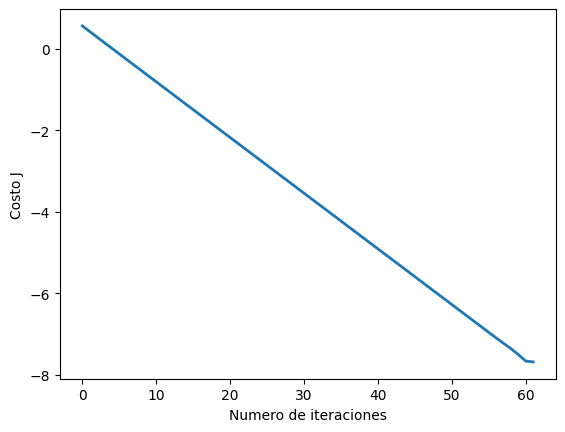

In [37]:
# Elegir algun valor para alpha (probar varias alternativas)
alpha = 0.0009
num_iters = 10000

# inicializa theta y ejecuta el descenso por el gradiente
theta = np.zeros(len(X_ready[0]))

theta, J_history = descensoGradiente(theta, X_ready, y_train, alpha, num_iters)

# Grafica la convergencia del costo
pyplot.plot(np.arange(len(J_history)), J_history, lw=2)
pyplot.xlabel('Numero de iteraciones')
pyplot.ylabel('Costo J')

# Muestra los resultados del descenso por el gradiente
print('theta calculado por el descenso por el gradiente: {:s}'.format(str(theta)))

# verificar si ingresa o no a la universidad
# X_array = [1, 1, 80, 66, 28, 0, 33.4, 0.675, 46]
# aprueba = sigmoid(np.dot(X_array, theta))   # Se debe cambiar esto

# print('Una persona con los siguientes datos [1, 1, 80, 66, 28, 0, 33.4, 0.675, 46] tiene como probabilida de ser diabetico:{:.0f}'.format(aprueba))